# Grocery Recommendation Project

1. Data Clustering on users  
2. Recommendation systems
  * Content-based filtering  
  * Collaborative filtering  
3. Market Basket analysis  
4. Website interface  

For this analysis I will be working as a Data Scientist for a grocery store that is looking to discover insights from sales data that could be used for targeted direct mail marketing (specific coupons mailed to customers), targeted email marketing ("An item you like has gone on sale!"), and online shopper recommendations to 'add to cart' based on similar items and also based on items other people who bought that item have purchased.  

If time permits, I may also perform a market basket analysis to forecast what products a customer is likely to purchase in their next order.

## Dataset information

This data was retrieved from Kaggle and was provided by Instacart for a market basket analysis competition in 2018.  

The data is divided into 6 files:

- **_Aisles.csv_**: 134 Unique aisle numbers and descriptions
- **_Departments.csv_**: 21 Unique department numbers and descriptions
- **_Products.csv_**: 49,688 Unique product ids, with description, aisle id, and department id
- **_Orders.csv_**: 3,421,083 Unique order id, with user id, order number, order_dow, order_hour_of_day, days_since_prior_order, and eval_set indicating if the order is in train, prior, or test
- **_Order_products_train.csv_**: Order id, product id, add to cart order, and reorder indicator
- **_Order_products_prior.csv_**: Order id, product id, add to cart order, and reorder indicator


Some ideas for exploration:

1. Look at ROI for each zip code, over the whole dataset, avg for each year, 3 year avg, 5 year avg, 10 year avg
2. Plot median sales price against ROI to get quadrants for comparison
3. Which zips have highest and lowest ROI?
4. Business case - choose highest ROI for small investors

## Exploratory Data Analysis

### Import and basic info

**Output** - aisles, orders, products, departments, order_products_prior, order_products_train

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from user_functions import *
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set default visualization parameters

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber, CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
sns.set_context("notebook", rc={"font.size":16, "axes.titlesize":20, "axes.labelsize":18})
sns.set(font='Franklin Gothic Book',
rc={'axes.axisbelow': False,
'axes.edgecolor': 'lightgrey',
# 'axes.edgecolor': 'white',
'axes.facecolor': 'None',
'axes.grid': False,
'axes.labelcolor': 'dimgrey',
# 'axes.labelcolor': 'white',
'axes.spines.right': False,
'axes.spines.top': False,
'axes.prop_cycle': plt.cycler(color=color_list),
'figure.facecolor': 'white',
'lines.solid_capstyle': 'round',
'patch.edgecolor': 'w',
'patch.force_edgecolor': True,
'text.color': 'dimgrey',
# 'text.color': 'white',    
'xtick.bottom': False,
'xtick.color': 'dimgrey',
# 'xtick.color': 'white',    
'xtick.direction': 'out',
'xtick.top': False,
'ytick.color': 'dimgrey',
# 'ytick.color': 'white',
'ytick.direction': 'out',
'ytick.left': False,
'ytick.right': False})
%matplotlib inline

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [3]:
aisles = pd.read_csv("Data/aisles.csv")
departments = pd.read_csv("Data/departments.csv")
order_products_prior = pd.read_csv("Data/order_products__prior.csv")
order_products_train = pd.read_csv("Data/order_products__train.csv")
orders = pd.read_csv("Data/orders.csv")
products = pd.read_csv("Data/products.csv")

In [4]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


### Checking for Nan values

Data is very clean. Nan values in orders.days_since_prior_order, but they are valid.

In [5]:
aisles.isna().sum()

aisle_id    0
aisle       0
dtype: int64

In [6]:
departments.isna().sum()

department_id    0
department       0
dtype: int64

In [7]:
products.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [8]:
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [9]:
orders.days_since_prior_order.value_counts()
# Nothing greater than 30 here so it must actually be '30+'

30.0    369323
7.0     320608
6.0     240013
4.0     221696
3.0     217005
5.0     214503
2.0     193206
8.0     181717
1.0     145247
9.0     118188
14.0    100230
10.0     95186
13.0     83214
11.0     80970
12.0     76146
0.0      67755
15.0     66579
16.0     46941
21.0     45470
17.0     39245
20.0     38527
18.0     35881
19.0     34384
22.0     32012
28.0     26777
23.0     23885
27.0     22013
24.0     20712
25.0     19234
29.0     19191
26.0     19016
Name: days_since_prior_order, dtype: int64

In [10]:
orders.head()
# order_id is a unique key for the order
# order_number is specific to a user
# seems like for any user, order 1 will have a Nan in days_since_prior_order since it is their first order

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [11]:
order_products_train.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [12]:
order_products_prior.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

### Analyze 'Products'
  
49688 unique products 

In [13]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [14]:
print(len(products))
print(products.aisle_id.nunique())
print(products.department_id.nunique())

49688
134
21


In [15]:
# How many products in each department and aisle?
# I guess these would be better/more informative with aisle and dept names
products_aisles = pd.merge(products, aisles, on = 'aisle_id', how = 'left')
products_desc = pd.merge(products_aisles, departments, on = 'department_id', how = 'left')
products_desc.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


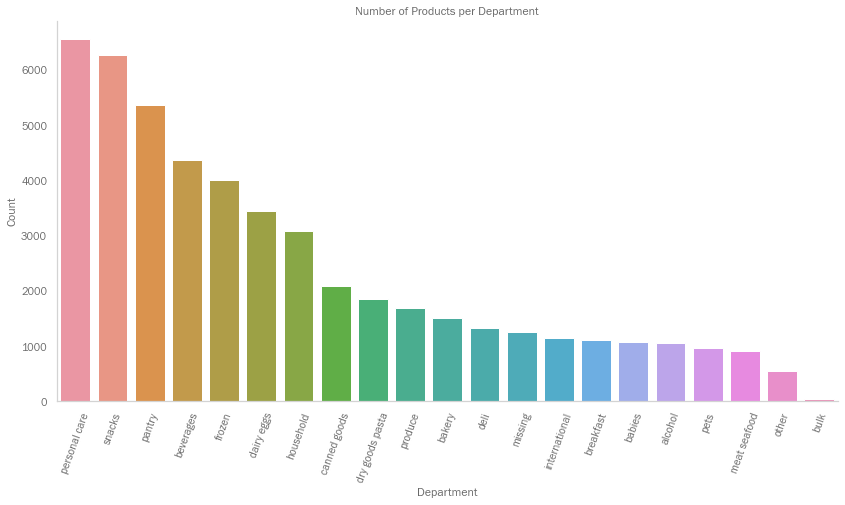

In [16]:
plt.figure(figsize = (14,7))
sns.countplot(x='department', data= products_desc, order = products_desc.department.value_counts().index)
plt.title('Number of Products per Department')
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Department')
plt.savefig('Images/products_by_department.png');

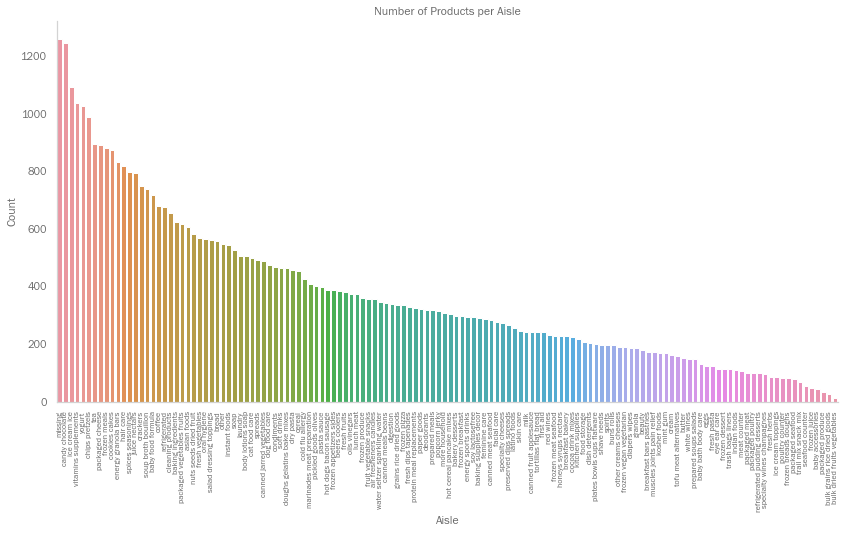

In [17]:
plt.figure(figsize = (14,7))
sns.countplot(x='aisle', data= products_desc, order = products_desc.aisle.value_counts().index)
plt.title('Number of Products per Aisle')
plt.xticks(rotation=90, fontsize = 8)
plt.ylabel('Count')
plt.xlabel('Aisle')
plt.savefig('Images/products_by_aisle.png');
# Uh oh, 'missing' is our most popular aisle
# And I see there is a 'missing' value for department above as well

In [18]:
products_desc[products_desc['aisle']=='missing']
# It appears that 1258 products have 'missing' aisle 100 and department 21

,product_id,product_name,aisle_id,department_id,aisle,department
37,38,Ultra Antibacterial Dish Liquid,100,21,missing,missing
71,72,Organic Honeycrisp Apples,100,21,missing,missing
109,110,Uncured Turkey Bologna,100,21,missing,missing
296,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",100,21,missing,missing
416,417,Classics Baby Binks Easter Chocolate Bunny,100,21,missing,missing
...,...,...,...,...,...,...
49552,49553,Organic Plain Skyr,100,21,missing,missing
49574,49575,Chocolate Vanilla Malt Custard,100,21,missing,missing
49640,49641,"8\"" Pecan Pie",100,21,missing,missing
49663,49664,Lemon Cayenne Drinking Vinegar,100,21,missing,missing


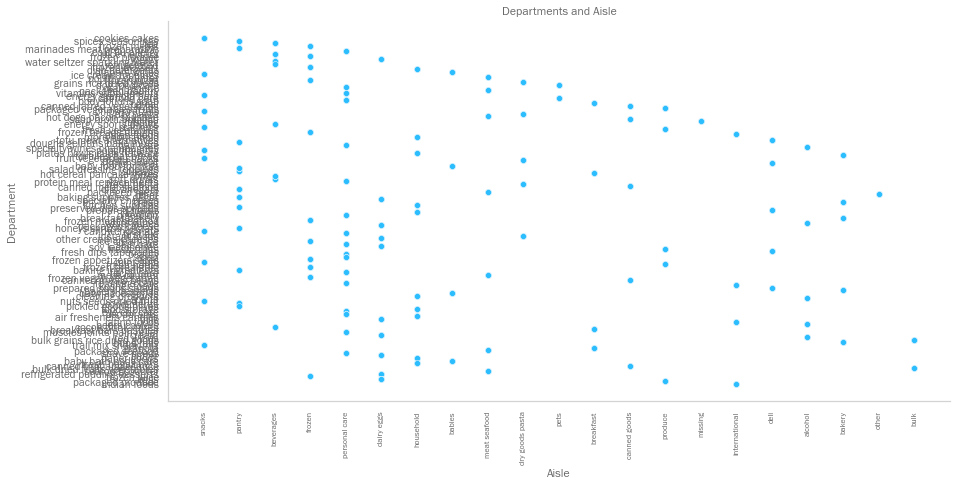

In [19]:
plt.figure(figsize = (14,7))
sns.scatterplot(y='aisle', x='department', data= products_desc)
plt.title('Departments and Aisle')
plt.xticks(rotation=90, fontsize = 8)
plt.ylabel('Department')
plt.xlabel('Aisle')
plt.savefig('Images/depts_by_aisle.png');

In [20]:
# Just confirming the one to many relationship between department and aisle
products_desc[products_desc['department']=='snacks']

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
15,16,Mint Chocolate Flavored Syrup,103,19,ice cream toppings,snacks
24,25,Salted Caramel Lean Protein & Fiber Bar,3,19,energy granola bars,snacks
31,32,Nacho Cheese White Bean Chips,107,19,chips pretzels,snacks
40,41,Organic Sourdough Einkorn Crackers Rosemary,78,19,crackers,snacks
...,...,...,...,...,...,...
49661,49662,Bacon Cheddar Pretzel Pieces,107,19,chips pretzels,snacks
49664,49665,Super Dark Coconut Ash & Banana Chocolate Bar,45,19,candy chocolate,snacks
49665,49666,Ginger Snaps Snacking Cookies,61,19,cookies cakes,snacks
49670,49671,Milk Chocolate Drops,45,19,candy chocolate,snacks


In [21]:
# An aisle only belongs to one department
products_desc[products_desc['aisle_id']==45]

,product_id,product_name,aisle_id,department_id,aisle,department
123,124,Sun Cups Dark Chocolate,45,19,candy chocolate,snacks
135,136,Simple,45,19,candy chocolate,snacks
183,184,Kisses Milk Chocolate Candy,45,19,candy chocolate,snacks
206,207,Minis Candy Bars,45,19,candy chocolate,snacks
226,227,Triple Chocolate Snack Size,45,19,candy chocolate,snacks
...,...,...,...,...,...,...
49503,49504,Dark Chocolate Peanut Butter Cups Miniatures,45,19,candy chocolate,snacks
49600,49601,Pomegranate Gummy Bears,45,19,candy chocolate,snacks
49619,49620,Milk Chocolate Mini's,45,19,candy chocolate,snacks
49664,49665,Super Dark Coconut Ash & Banana Chocolate Bar,45,19,candy chocolate,snacks


### Analyze Orders

In [22]:
print(len(orders))
print(orders.order_id.min())
print(orders.order_id.max())

3421083
1
3421083


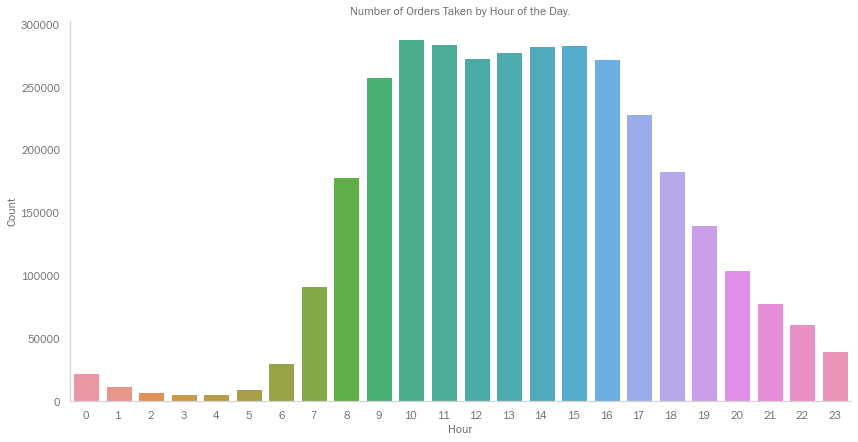

In [23]:
plt.figure(figsize = (14,7))
sns.countplot(x='order_hour_of_day', data= orders)
plt.title('Number of Orders Taken by Hour of the Day.')
plt.ylabel('Count')
plt.xlabel('Hour')
plt.savefig('Images/orders_by_hour.png');

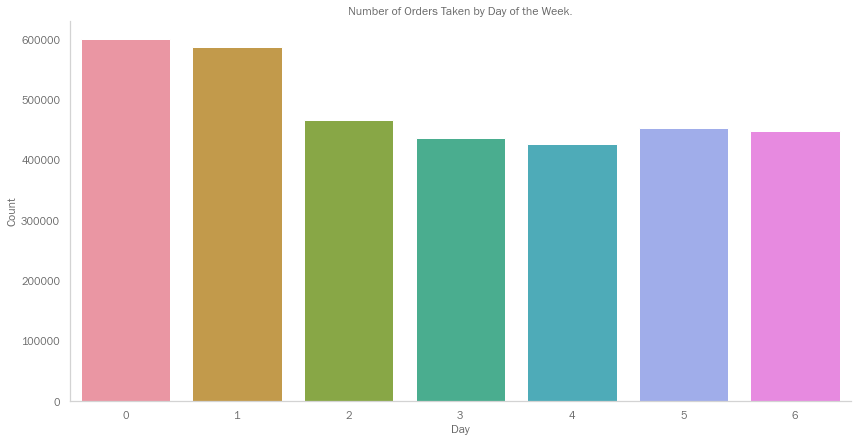

In [24]:
plt.figure(figsize = (14,7))
sns.countplot(x='order_dow', data= orders)
plt.title('Number of Orders Taken by Day of the Week.')
plt.ylabel('Count')
plt.xlabel('Day')
plt.savefig('Images/orders_by_dow.png');

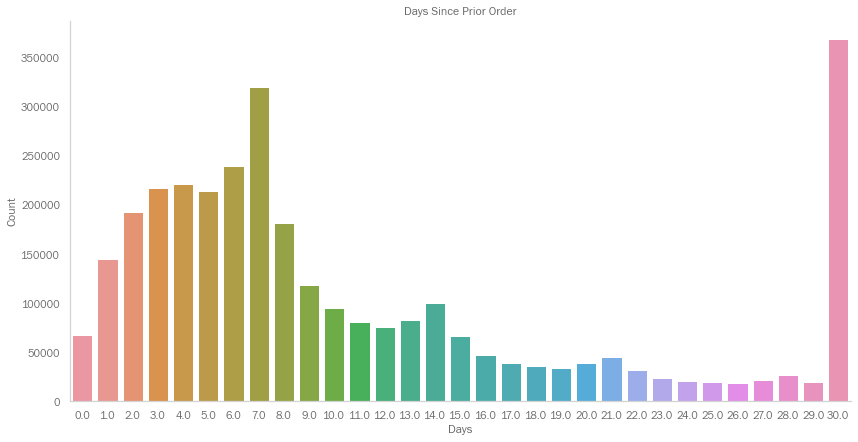

In [25]:
plt.figure(figsize = (14,7))
sns.countplot(x='days_since_prior_order', data= orders)
plt.title('Days Since Prior Order')
plt.ylabel('Count')
plt.xlabel('Days')
plt.savefig('Images/days_since_order.png');

# Spikes at 7, 14, 21, and 28 indicate people who reorder weekly, or every 2 or three weeks but on the same day
# Does 0.0 days mean someone ordered twice in the same day?
# Surprising how many people order more than once a week
# 30 does seem to indicate 30 or more days since last order

In [26]:
orders.head(15)
# Appears to be sorted by user_id and then order_number
# Most recent order_number per user_id is in the train(or test) set, others in prior
# First order per user has NaN in days_since

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [27]:
orders.sort_values('order_id') # Just checking that it has all the order_ids starting at 1

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1868044,1,112108,train,4,4,10,9.0
3355525,2,202279,prior,3,5,9,8.0
3417191,3,205970,prior,16,5,17,12.0
2958007,4,178520,prior,36,1,9,7.0
2593373,5,156122,prior,42,6,16,9.0
...,...,...,...,...,...,...,...
1809968,3421079,108687,prior,6,1,13,0.0
877324,3421080,52726,prior,2,1,11,2.0
1949724,3421081,117076,prior,1,3,11,NaN
2903252,3421082,175185,prior,23,2,18,4.0


In [28]:
orders_test = orders[orders['eval_set']=='test'] # 75000 orders in our test set
# So basically for these test orders, I don't have the answers.  I don't know what products were ordered.
orders_test

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0
...,...,...,...,...,...,...,...
3420918,2728930,206202,test,23,2,17,6.0
3420929,350108,206204,test,5,4,14,14.0
3421001,1043943,206206,test,68,0,20,0.0
3421018,2821651,206207,test,17,2,13,14.0


In [29]:
orders[orders['user_id']==3] # But I have all of this user's order/products in prior

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
26,1374495,3,prior,1,1,14,NaN
27,444309,3,prior,2,3,19,9.0
28,3002854,3,prior,3,3,16,21.0
29,2037211,3,prior,4,2,18,20.0
30,2710558,3,prior,5,0,17,12.0
31,1972919,3,prior,6,0,16,7.0
32,1839752,3,prior,7,0,15,7.0
33,3225766,3,prior,8,0,17,7.0
34,3160850,3,prior,9,0,16,7.0
35,676467,3,prior,10,3,16,17.0


### Analyze Order_products_train and _prior

In [30]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [31]:
print(len(order_products_train)) # Has 1,384,617 order/products
print(order_products_train.order_id.min()) # starts with order number 1
print(order_products_train.order_id.max())
print(order_products_train.order_id.nunique()) # Has 131,209 unique orders

1384617
1
3421070
131209


In [32]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [33]:
print(len(order_products_prior)) # Has 32,434,489 order/products
print(order_products_prior.order_id.min()) # starts with order number 2
print(order_products_prior.order_id.max())
print(order_products_prior.order_id.nunique()) # Has 3,214,874 unique orders

32434489
2
3421083
3214874


In [34]:
order_products_prior[order_products_prior.order_id == 2]

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0


In [35]:
orders[orders.order_id == 2]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3355525,2,202279,prior,3,5,9,8.0


In [36]:
orders[orders.user_id == 202279]
# This user's third order was order number 2.  Need to be sure not to think order_id is chronological.

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3355523,2894949,202279,prior,1,5,9,NaN
3355524,1500071,202279,prior,2,4,13,20.0
3355525,2,202279,prior,3,5,9,8.0
3355526,3058248,202279,prior,4,3,14,30.0
3355527,2808715,202279,prior,5,5,13,9.0
3355528,132412,202279,prior,6,5,9,30.0
3355529,2382766,202279,prior,7,1,14,24.0
3355530,104690,202279,prior,8,6,10,30.0
3355531,1050357,202279,train,9,1,14,30.0


In [37]:
order_products_train[order_products_train.order_id == 1050357]

,order_id,product_id,add_to_cart_order,reordered
429686,1050357,33120,1,1
429687,1050357,1003,2,1
429688,1050357,21543,3,1
429689,1050357,20995,4,1
429690,1050357,46064,5,0
429691,1050357,20168,6,0
429692,1050357,42824,7,1
429693,1050357,4461,8,1
429694,1050357,45002,9,1
429695,1050357,8693,10,0


In [38]:
# So what do I know about this user...

# They have ordered 9 times.
len(orders[orders.user_id == 202279])

9

In [39]:
# They usually order on day 5 (presumably Friday)
orders[orders.user_id == 202279].order_dow.mode()

0    5
dtype: int64

In [40]:
# They average 22.6 days between orders
orders[orders.user_id == 202279].days_since_prior_order.mean()

22.625

In [41]:
# They order around 11:30 am.
orders[orders.user_id == 202279].order_hour_of_day.mean()

11.666666666666666

In [42]:
# These are their order numbers
list(orders[orders.user_id == 202279]['order_id'].values)

[2894949, 1500071, 2, 3058248, 2808715, 132412, 2382766, 104690, 1050357]

In [43]:
# But what products have they ordered... merging tables will help here
order_products_prior[order_products_prior['order_id'].isin(list(orders[orders.user_id == 202279]['order_id'].values))]

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
28997578,3058248,27531,4,0
28997579,3058248,2944,5,0
28997580,3058248,38226,6,0
28997581,3058248,35106,7,0


## Data Preprocessing

### Merge order_products together

Output: merged_order_products, order_products_desc

In [44]:
print(len(order_products_train))
print(len(order_products_prior))

1384617
32434489


In [45]:
# The dataframe of all order products should be the length of these two together
len(order_products_train)+len(order_products_prior)

33819106

In [46]:
# These two dataframes shouldn't have any overlap.  I need an outer join to merge them together.
merged_order_products = pd.merge(order_products_train, order_products_prior, how = 'outer')
merged_order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [47]:
len(merged_order_products)

33819106

In [48]:
# This has an entry for each ordered product.  If we combine it with aisle and department we can see which products
# are ordered the most.
order_products_desc = pd.merge(merged_order_products, products_desc, on = 'product_id')
order_products_desc.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,816049,49302,7,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,1242203,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,1383349,49302,11,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
4,1787378,49302,8,0,Bulgarian Yogurt,120,16,yogurt,dairy eggs


In [49]:
# Very cool.  People really like their bananas.
order_products_desc['product_name'].value_counts()

Banana                                                    491291
Bag of Organic Bananas                                    394930
Organic Strawberries                                      275577
Organic Baby Spinach                                      251705
Organic Hass Avocado                                      220877
                                                           ...  
Organic Aleppo Pepper                                          1
Petite Black Eyed Peas                                         1
Molasses, Bead                                                 1
Pure Performance Restorative Shampoo Chamomile & Honey         1
Organic Better Rest Tea Blend                                  1
Name: product_name, Length: 49685, dtype: int64

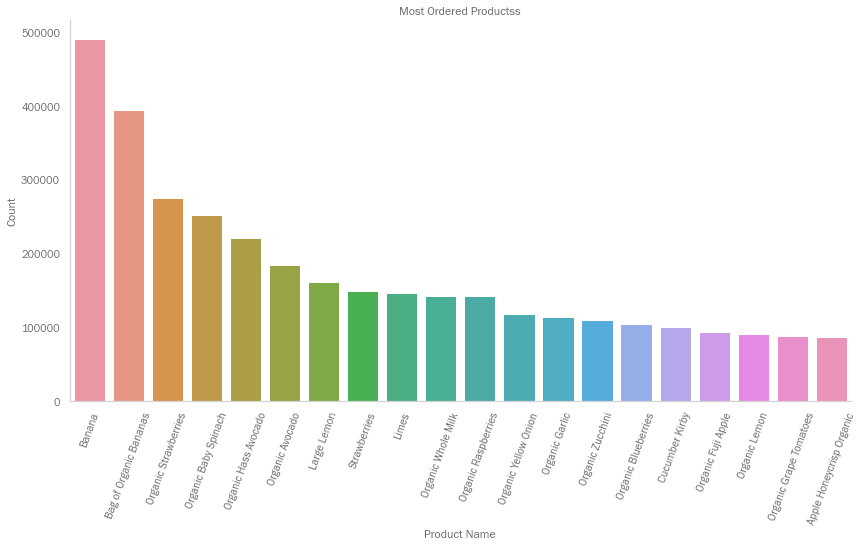

In [50]:
plt.figure(figsize = (14,7))
sns.countplot(x='product_name', data= order_products_desc, 
              order = order_products_desc.product_name.value_counts().index[:20])
plt.title('Most Ordered Productss')
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Product Name')
plt.savefig('Images/ordered_products_by_name.png');

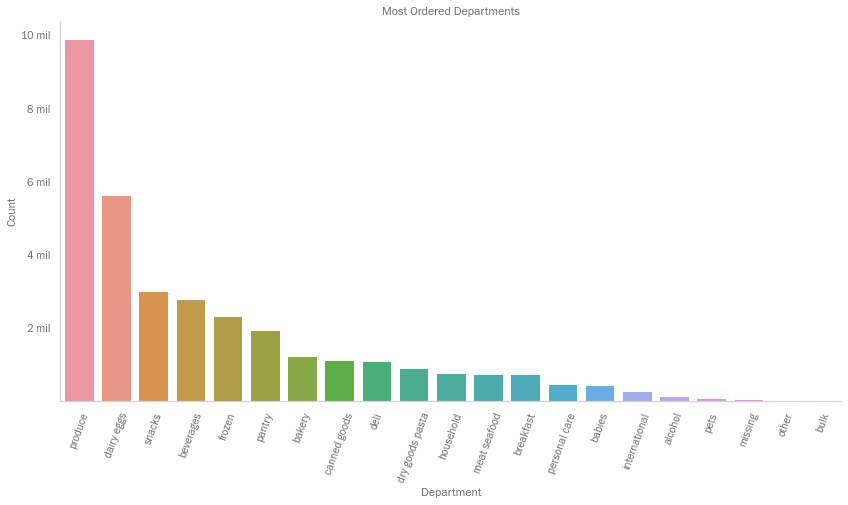

In [51]:
plt.figure(figsize = (14,7))
sns.countplot(x='department', data= order_products_desc, order = order_products_desc.department.value_counts().index)
plt.title('Most Ordered Departments')
plt.xticks(rotation=70)
plt.yticks([2000000,4000000,6000000,8000000,10000000],['2 mil','4 mil','6 mil','8 mil','10 mil'])
plt.ylabel('Count')
plt.xlabel('Department')
plt.savefig('Images/ordered_products_by_department.png');

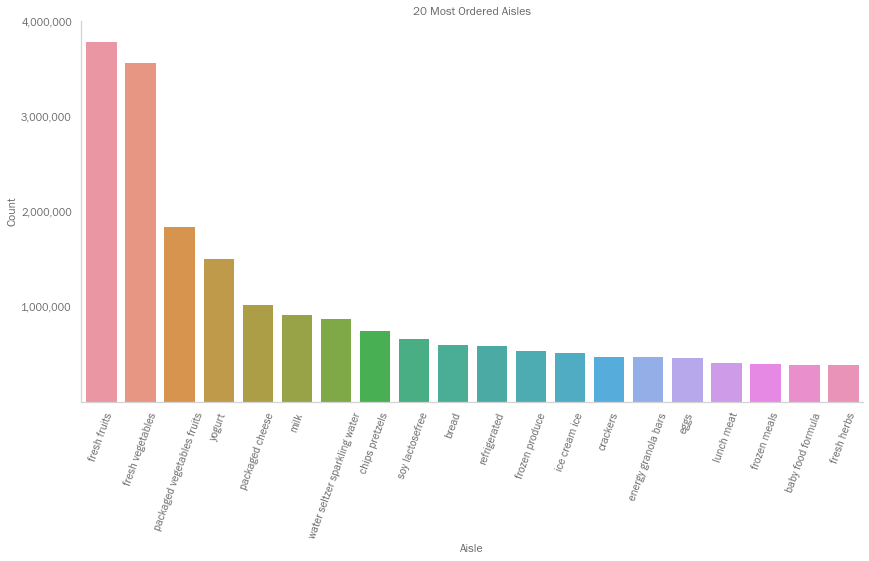

In [52]:
plt.figure(figsize = (14,7))
sns.countplot(x='aisle', data= order_products_desc, order = order_products_desc.aisle.value_counts().index[:20])
plt.title('20 Most Ordered Aisles')
plt.xticks(rotation=70)
plt.yticks([1000000,2000000,3000000,4000000],['1,000,000','2,000,000','3,000,000','4,000,000'])
plt.ylabel('Count')
plt.xlabel('Aisle')
plt.savefig('Images/ordered_products_by_aisle.png');

### Merge user orders

Output: merged_orders

In [53]:
# Now merge the orders with the ordered prodcuts, combining on order_id
# This is a lot of info. We will trim some out before modeling.
merged_orders = pd.merge(orders, order_products_desc, on = 'order_id')
merged_orders.head() # Because the products showing are from the 1st order for this user, they all have Nan in days_since
# Because pd.merge defaults to an inner join, the test orders are not in this dataframe because they had no products.

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks
2,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,dairy eggs
3,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household
4,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,popcorn jerky,snacks


In [54]:
len(merged_orders)

33819106

In [55]:
merged_orders[merged_orders['user_id']==3] # We see 12 orders, 88 products, no test order

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
296,1374495,3,prior,1,1,14,NaN,39190,5,0,Vanilla Unsweetened Almond Milk,91,16,soy lactosefree,dairy eggs
297,1374495,3,prior,1,1,14,NaN,16797,4,0,Strawberries,24,4,fresh fruits,produce
298,1374495,3,prior,1,1,14,NaN,9387,1,0,Granny Smith Apples,24,4,fresh fruits,produce
299,1374495,3,prior,1,1,14,NaN,21903,7,0,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
300,1374495,3,prior,1,1,14,NaN,39922,8,0,Celery Sticks,123,4,packaged vegetables fruits,produce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,1402502,3,prior,12,1,15,15.0,18599,2,1,Garlic Couscous,4,9,instant foods,dry goods pasta
380,1402502,3,prior,12,1,15,15.0,21903,4,1,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
381,1402502,3,prior,12,1,15,15.0,47766,5,1,Organic Avocado,24,4,fresh fruits,produce
382,1402502,3,prior,12,1,15,15.0,24810,6,1,Organic Lightly Salted Brown Rice Cakes,78,19,crackers,snacks


In [56]:
orders[orders['user_id']==3]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
26,1374495,3,prior,1,1,14,NaN
27,444309,3,prior,2,3,19,9.0
28,3002854,3,prior,3,3,16,21.0
29,2037211,3,prior,4,2,18,20.0
30,2710558,3,prior,5,0,17,12.0
31,1972919,3,prior,6,0,16,7.0
32,1839752,3,prior,7,0,15,7.0
33,3225766,3,prior,8,0,17,7.0
34,3160850,3,prior,9,0,16,7.0
35,676467,3,prior,10,3,16,17.0


In [57]:
# Creating the test set of orders
test = orders[orders['eval_set']=='test']
test.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [58]:
# Now I can see everything a particular user has ordered, and how often
merged_orders[merged_orders['user_id']==3]['product_name'].value_counts()

Vanilla Unsweetened Almond Milk                    10
Organic Avocado                                     9
Organic Baby Spinach                                8
Granny Smith Apples                                 5
Unsweetened Chocolate Almond Breeze Almond Milk     5
Organic Peeled Whole Baby Carrots                   4
Garlic Couscous                                     4
All Natural No Stir Creamy Almond Butter            3
Organic Lightly Salted Brown Rice Cakes             3
Crackers, Crispy, Cheddar                           3
Strawberries                                        3
Organic Whole String Cheese                         3
Green Beans                                         2
Wheat Gluten Free Waffles                           2
Original Rotisserie Chicken                         2
Brussels Sprouts                                    2
Electrolyte Water                                   2
Birthday Cake Light Ice Cream                       2
Chocolate Ice Cream         

In [59]:
# Here is every time this user ordered Organic Avocado
merged_orders[(merged_orders['user_id']==3) & (merged_orders['product_name']=='Organic Avocado')]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
301,1374495,3,prior,1,1,14,NaN,47766,6,0,Organic Avocado,24,4,fresh fruits,produce
318,3002854,3,prior,3,3,16,21.0,47766,2,1,Organic Avocado,24,4,fresh fruits,produce
331,2710558,3,prior,5,0,17,12.0,47766,4,1,Organic Avocado,24,4,fresh fruits,produce
341,1972919,3,prior,6,0,16,7.0,47766,4,1,Organic Avocado,24,4,fresh fruits,produce
359,3225766,3,prior,8,0,17,7.0,47766,6,1,Organic Avocado,24,4,fresh fruits,produce
365,3160850,3,prior,9,0,16,7.0,47766,2,1,Organic Avocado,24,4,fresh fruits,produce
369,676467,3,prior,10,3,16,17.0,47766,3,1,Organic Avocado,24,4,fresh fruits,produce
376,521107,3,prior,11,0,18,11.0,47766,2,1,Organic Avocado,24,4,fresh fruits,produce
381,1402502,3,prior,12,1,15,15.0,47766,5,1,Organic Avocado,24,4,fresh fruits,produce


## Clustering

In [60]:
# Now I want to experiment with clustering the 'similar' users together
# But what data do I need for each user?  Some kind of summary statistics?
# I guess I need each product to be a column, with the number of times it was ordered?
# Product level is too granular so I am going to try aisle

In [61]:
merged_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks
2,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,dairy eggs
3,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household
4,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,popcorn jerky,snacks


In [62]:
# What don't I need for my user dataframe?
# Since product level is too granular, I will capture the aisle
user_info = merged_orders[['user_id', 'order_number', 'order_dow', 'order_hour_of_day', 
                           'days_since_prior_order', 'aisle']]

In [63]:
user_info.head()

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,1,1,2,8,NaN,soft drinks
1,1,1,2,8,NaN,popcorn jerky
2,1,1,2,8,NaN,soy lactosefree
3,1,1,2,8,NaN,paper goods
4,1,1,2,8,NaN,popcorn jerky


### Get dummy variables for each aisle

In [64]:
user_data = pd.get_dummies(user_info, prefix=None, columns=['aisle'])

In [65]:
user_data
# Group By User_id
# I need max of order_number
# Mode of order_dow, median of order_hour_of_day, mean of days_since
# Sum of each aisle

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
0,1,1,2,8,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2,8,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,2,8,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,2,8,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,2,8,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33819101,206209,14,6,14,30.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33819102,206209,14,6,14,30.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33819103,206209,14,6,14,30.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33819104,206209,14,6,14,30.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
user_data['aisle_soft drinks'].value_counts()

0    33445290
1      373816
Name: aisle_soft drinks, dtype: int64

### Group By each User Id

In [67]:
# Splitting the data in thirds to use groupby then will rejoin them
user_data1 = user_data[user_data['user_id'] <= 65000]
user_data2 = user_data[(user_data['user_id'] <= 135000) & (user_data['user_id'] > 65000)]
user_data3 = user_data[user_data['user_id'] > 135000]

In [68]:
grouped_user1 = user_data1.groupby('user_id').sum()

In [69]:
grouped_user2 = user_data2.groupby('user_id').sum()

In [70]:
grouped_user3 = user_data3.groupby('user_id').sum()

In [71]:
# Go back to user_data and drop the aisle info before I group the other variables in different ways
user_data1_noaisles = user_data1.iloc[:,:5]
user_data2_noaisles = user_data2.iloc[:,:5]
user_data3_noaisles = user_data3.iloc[:,:5]

In [72]:
# Cool.  Found a way to group each varaiable differently.
group1 = user_data1_noaisles.groupby('user_id').agg({'order_number': 'max', 'order_dow': lambda x:x.value_counts().index[0], 
                                            'order_hour_of_day': 'median', 'days_since_prior_order': 'mean'})
group2 = user_data2_noaisles.groupby('user_id').agg({'order_number': 'max', 'order_dow': lambda x:x.value_counts().index[0], 
                                            'order_hour_of_day': 'median', 'days_since_prior_order': 'mean'})
group3 = user_data3_noaisles.groupby('user_id').agg({'order_number': 'max', 'order_dow': lambda x:x.value_counts().index[0], 
                                            'order_hour_of_day': 'median', 'days_since_prior_order': 'mean'})

In [73]:
group1

,order_number,order_dow,order_hour_of_day,days_since_prior_order
user_id,,,,
1,11,4,8.0,19.200000
2,15,1,10.0,18.009390
3,12,0,16.0,11.487179
4,5,4,13.0,15.357143
5,5,0,16.0,12.314286
...,...,...,...,...
64996,15,2,14.0,17.057143
64997,5,0,11.0,20.869048
64998,4,5,10.0,24.521739


In [74]:
# get number of orders for each user and add to grouped_user dfs
grouped_user1['num_orders'] = group1.order_number
grouped_user2['num_orders'] = group2.order_number
grouped_user3['num_orders'] = group3.order_number

In [75]:
grouped_user1['mean_days_since'] = group1.days_since_prior_order
grouped_user2['mean_days_since'] = group2.days_since_prior_order
grouped_user3['mean_days_since'] = group3.days_since_prior_order

In [76]:
grouped_user1['mode_order_dow'] = group1.order_dow
grouped_user2['mode_order_dow'] = group2.order_dow
grouped_user3['mode_order_dow'] = group3.order_dow

In [77]:
grouped_user1['median_order_hour'] = group1.order_hour_of_day
grouped_user2['median_order_hour'] = group2.order_hour_of_day
grouped_user3['median_order_hour'] = group3.order_hour_of_day

In [78]:
grouped_user1.drop(columns=['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], inplace=True)
grouped_user2.drop(columns=['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], inplace=True)
grouped_user3.drop(columns=['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], inplace=True)

In [121]:
grouped_users = pd.concat([grouped_user1, grouped_user2, grouped_user3], axis=0)

In [122]:
grouped_users

,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,aisle_baking ingredients,aisle_baking supplies decor,aisle_beauty,aisle_beers coolers,...,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt,num_orders,mean_days_since,mode_order_dow,median_order_hour
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,11,19.200000,4,8.0
2,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,42.0,15,18.009390,1,10.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,12,11.487179,0,16.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,5,15.357143,4,13.0
5,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,5,12.314286,0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.0,4,14.705882,1,16.0
206206,0.0,4.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,67,4.042705,0,18.0
206207,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,11.0,0.0,15.0,16,14.879397,1,12.0


In [123]:
# This function came from a Medium article by Adam Ross Nelson to rearrange columns in a df
def movecol(df, cols_to_move=[], ref_col='', place='After'):
    
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

In [124]:
grouped_users = movecol(grouped_users, 
             cols_to_move=['num_orders', 'mode_order_dow', 'median_order_hour', 'mean_days_since'], 
             ref_col='aisle_air fresheners candles',
             place='Before')
grouped_users

,num_orders,mode_order_dow,median_order_hour,mean_days_since,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,11,4,8.0,19.200000,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,15,1,10.0,18.009390,0.0,3.0,0.0,0.0,0.0,0.0,...,3.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,42.0
3,12,0,16.0,11.487179,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,5,4,13.0,15.357143,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,5,0,16.0,12.314286,1.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,4,1,16.0,14.705882,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
206206,67,0,18.0,4.042705,0.0,4.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
206207,16,1,12.0,14.879397,0.0,0.0,0.0,0.0,1.0,0.0,...,3.0,4.0,0.0,2.0,1.0,0.0,0.0,11.0,0.0,15.0


### Run KMeans clustering

In [125]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_users = scaler.fit_transform(grouped_users)

In [126]:
scaled_users

array([[-0.31368362,  0.63094204, -1.98290635, ..., -0.37143228,
        -0.08668691, -0.28458752],
       [-0.07361924, -0.75026401, -1.26590407, ..., -0.19699129,
        -0.08668691,  1.85881583],
       [-0.25366752, -1.21066602,  0.88510277, ..., -0.19699129,
        -0.08668691, -0.39175769],
       ...,
       [-0.01360315, -0.75026401, -0.54890179, ...,  0.58799319,
        -0.08668691,  0.41201857],
       [ 1.96692792, -0.28986199,  0.16810049, ..., -0.37143228,
        -0.08668691,  1.37655008],
       [-0.13363534, -0.75026401, -0.54890179, ..., -0.37143228,
        -0.08668691, -0.23100244]])

In [127]:
from sklearn.cluster import KMeans
random_state = 12

'''The classical EM-style algorithm is “full”. The “elkan” variation is more efficient on data with well-defined clusters,
by using the triangle inequality. However it’s more memory intensive due to the allocation of an extra array of shape 
(n_samples, n_clusters).'''

# Is having 20 separate market segments helpful?  Can I figure out what make them different and target that?  

k_means_13 = KMeans(n_clusters=13, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_14 = KMeans(n_clusters=14, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_15 = KMeans(n_clusters=15, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_16 = KMeans(n_clusters=16, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_17 = KMeans(n_clusters=17, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_18 = KMeans(n_clusters=18, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_19 = KMeans(n_clusters=19, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_10 = KMeans(n_clusters=10, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_11 = KMeans(n_clusters=11, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_12 = KMeans(n_clusters=12, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_20 = KMeans(n_clusters=20, random_state=random_state, algorithm='full').fit(scaled_users)

k_list = [k_means_10, k_means_11, k_means_12, k_means_13, 
          k_means_14, k_means_15, k_means_16, k_means_17, k_means_18, k_means_19, k_means_20]

In [128]:
from sklearn.metrics import calinski_harabasz_score

CH_score = []

for model in k_list:
    labels = model.labels_
    CH_score.append(calinski_harabasz_score(grouped_users, labels))

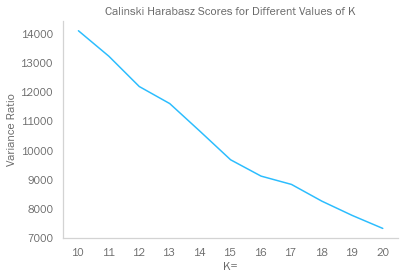

In [129]:
# Need to decide if I keep going with more clusters
# Previous k_means_20 on unscaled data had CH around 16000, now scaled it is at 8000

plt.plot([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], CH_score)
plt.xticks([10,11,12,13,14,15,16,17,18,19,20])
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.savefig('Images/ch_scaled_scores.png');

In [130]:
# Looking at Within Cluster Sum of Squares

wcss_score = []

for model in k_list:
    labels = model.labels_
    wcss_score.append(model.inertia_)

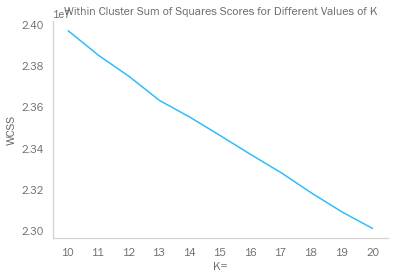

In [131]:
plt.plot([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], wcss_score)
plt.xticks([10,11,12,13,14,15,16,17,18,19,20])
plt.title('Within Cluster Sum of Squares Scores for Different Values of K')
plt.ylabel('WCSS')
plt.xlabel('K=')
plt.savefig('Images/wcss_scores.png');

In [132]:
# Silhouette score 1 is good, -1 is bad, near 0 means overlapping custers

from sklearn import metrics
metrics.silhouette_score(grouped_users, k_means_20.labels_, sample_size = 30000, random_state = random_state)

0.1716260835041877

In [133]:
metrics.silhouette_score(grouped_users, k_means_19.labels_, sample_size = 30000, random_state = random_state)

0.17220397175003255

In [134]:
# OK let's focus on k_means_20 and have a look at our clusters

k_means_20.labels_

array([12,  1, 12, ...,  1,  6,  1])

In [135]:
# Add cluster assignment to the grouped_users dataframe
grouped_users['cluster'] = k_means_20.labels_

### Analyze clusters

In [136]:
# There are top 3 big clusters and lots of smaller.  May be hard to determine what the big clusters have in common.
grouped_users.cluster.value_counts()

12    112042
1      47053
4      16295
18      9216
3       4569
6       4058
14      3282
10      1967
8       1345
5        938
16       905
2        854
13       742
9        673
19       641
11       608
0        489
17       246
7        154
15       132
Name: cluster, dtype: int64

In [137]:
# Now take the grouped users and group them by cluster

# For each user, I took the mode of their order_dow.  Now I am taking the median value for the cluster.

# cluster_data = grouped_users.groupby('cluster').agg({'num_orders': 'median', 
#                                                      'mode_order_dow': lambda x:x.value_counts().index[0], 
#                                                      'median_order_hour': 'median', 'mean_days_since': 'mean'})
cluster_data = grouped_users.groupby('cluster').median()

In [138]:
cluster_data # This is the median info for each cluster

# I can see cluster 7 has a lot of baby products

,num_orders,mode_order_dow,median_order_hour,mean_days_since,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
cluster,,,,,,,,,,,,,,,,,,,,,
0,41.0,2.0,13.0,8.071685,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,11.0
1,14.0,2.0,14.0,13.491803,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
2,57.0,2.0,11.0,6.180689,0.0,1.0,0.0,0.0,0.0,0.0,...,6.0,20.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,61.0
3,29.0,2.0,13.5,10.267296,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,8.0
4,30.0,1.0,13.0,9.890710,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,11.0
5,33.0,2.0,14.0,9.842865,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0
6,46.0,1.0,13.0,7.703537,0.0,1.0,0.0,0.0,2.5,0.0,...,4.0,1.0,0.0,2.0,0.0,0.0,0.0,5.0,0.0,30.0
7,55.0,2.0,13.0,6.311090,0.0,1.0,12.5,0.0,7.0,0.0,...,4.0,2.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,22.5
8,65.0,1.0,13.0,5.976703,0.0,4.0,0.0,0.0,1.0,0.0,...,10.0,2.0,0.0,6.0,0.0,0.0,0.0,9.0,0.0,44.0


In [139]:
# These are the users that make up cluster 7, and yes they have a lot of baby products

grouped_users[grouped_users['cluster'] == 7]

,num_orders,mode_order_dow,median_order_hour,mean_days_since,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,...,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
313,100,5,8.0,2.236200,0.0,1.0,27.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,7
652,95,4,15.0,3.734280,0.0,0.0,24.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,12.0,0.0,1.0,7
1022,79,3,15.0,4.215146,0.0,2.0,9.0,0.0,89.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,7.0,0.0,11.0,7
3639,17,2,16.0,3.702238,2.0,1.0,10.0,0.0,15.0,0.0,...,0.0,0.0,2.0,5.0,1.0,1.0,24.0,0.0,13.0,7
4425,26,1,14.0,9.049724,0.0,0.0,9.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200275,47,4,12.0,8.133333,0.0,22.0,7.0,0.0,58.0,0.0,...,31.0,0.0,0.0,0.0,5.0,0.0,34.0,0.0,7.0,7
201043,37,5,11.0,8.781250,0.0,0.0,15.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,7
201185,89,6,13.0,4.622980,0.0,3.0,15.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,2.0,0.0,31.0,0.0,1.0,7


In [140]:
# These are all of cluster 7's values that aren't zero... still 62 of them

cluster_data.iloc[7,(cluster_data.loc[7].values > 0)]

num_orders                             55.00000
mode_order_dow                          2.00000
median_order_hour                      13.00000
mean_days_since                         6.31109
aisle_asian foods                       1.00000
                                         ...   
aisle_spreads                           4.00000
aisle_tea                               2.00000
aisle_tortillas flat bread              1.00000
aisle_water seltzer sparkling water     9.00000
aisle_yogurt                           22.50000
Name: 7, Length: 62, dtype: float64

### Use TSNE to convert cluster data to 3D

In [141]:
# Convert to three dimensional for graphing

from sklearn.manifold import TSNE

cluster_embedded = TSNE(n_components=3).fit_transform(cluster_data)

In [142]:
# Create dataframe to plot
cluster_embedded_df = pd.DataFrame(cluster_embedded, index = cluster_data.index, columns = ['1','2','3'])
cluster_embedded_df.reset_index(inplace=True)
cluster_embedded_df

,cluster,1,2,3
0,0,-184.129517,225.756119,-50.419243
1,1,20.290453,-350.654785,-53.920628
2,2,-241.958191,-194.922043,194.459610
3,3,-507.401001,375.735229,-8.942498
4,4,204.930099,-80.944084,-201.231659
5,5,843.744080,1354.432129,328.379028
6,6,134.069366,-182.982956,268.078918
7,7,-24.426239,-53.781498,8.458076
8,8,407.137939,66.602379,-19.059978
9,9,-152.565125,124.569481,269.527100


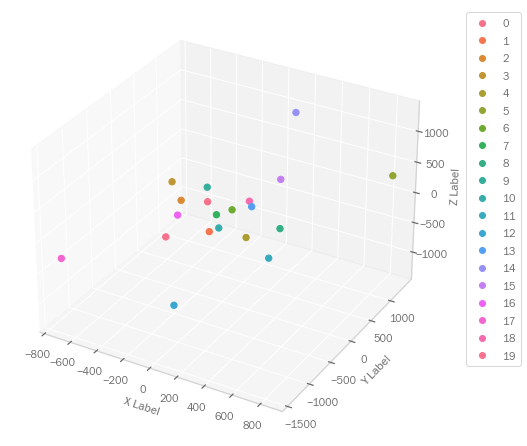

In [143]:
import re, seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(cluster_embedded_df['1'], cluster_embedded_df['2'], cluster_embedded_df['3'], 
                s=40, c=cluster_embedded_df['cluster'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(num=20), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("Images/scatter_hue.png", bbox_inches='tight')

In [144]:
# This shows clusters 5, 11, 12, 14, and 17 as being very separate from the rest

import plotly.express as px

fig = px.scatter_3d(cluster_embedded_df, x='1', y='2', z='3', color='cluster')
fig.show()

In [145]:
# Can I plot all of the users with their cluster color?
# This took somewhere between 2 and 3 hours to run.
# This is actually for a different set of clusters, but still interesting to see.

# user_embedded = TSNE(n_components=3).fit_transform(grouped_users.drop(columns='cluster'))

In [146]:
# pickle.dump(user_embedded, open("user_embedded.p", "wb"))

In [147]:
user_embedded = pickle.load(open("user_embedded.p", "rb"))

In [148]:
user_embedded

array([[ -6.7842526 ,   5.186436  ,  -7.4286184 ],
       [ -3.8616388 ,  -5.4635086 ,  12.013832  ],
       [  6.1933327 , -11.752681  ,   4.478235  ],
       ...,
       [  0.5414005 ,  -6.9421434 ,   8.786815  ],
       [-11.715099  ,  -0.99051756,   4.471662  ],
       [  9.098553  ,  -4.0437484 ,   5.5213437 ]], dtype=float32)

In [149]:
# Create dataframe to plot
user_embedded_df = pd.DataFrame(user_embedded, index = grouped_users.index, columns = ['1','2','3'])
user_embedded_df.reset_index(inplace=True)
user_embedded_df['cluster'] = k_means_20.labels_
user_embedded_df

,user_id,1,2,3,cluster
0,1,-6.784253,5.186436,-7.428618,12
1,2,-3.861639,-5.463509,12.013832,1
2,3,6.193333,-11.752681,4.478235,12
3,4,4.557354,8.393017,-7.494102,12
4,5,8.898149,-2.854837,-2.553604,12
...,...,...,...,...,...
206204,206205,11.458263,0.014673,-3.364238,12
206205,206206,4.548011,-12.448774,12.503222,4
206206,206207,0.541400,-6.942143,8.786815,1
206207,206208,-11.715099,-0.990518,4.471662,6


In [150]:
fig = px.scatter_3d(user_embedded_df.sample(200), x='1', y='2', z='3', color='cluster')
fig.show()

### Cluster Breakdown

In [151]:
# Create a way to compare clusters.  Find if they have max or min values for any features.

cluster_metrics = {}
for cluster in cluster_data.index:
    cluster_list = [grouped_users.cluster.value_counts()[cluster]]
    for col in cluster_data.columns:
        if (cluster_data.loc[:,col].max() > 0) & (cluster_data.loc[:,col].idxmax() == cluster):
            cluster_list.append(('max ' + col, cluster_data.loc[cluster,col]))
        if (cluster_data.loc[:,col].min() > 0) & (cluster_data.loc[:,col].idxmin() == cluster):
                cluster_list.append(('min ' + col, cluster_data.loc[cluster,col]))
    cluster_metrics[cluster] = cluster_list

In [152]:
cluster_metrics

{0: [489, ('max aisle_packaged meat', 13.0)],
 1: [47053, ('max median_order_hour', 14.0)],
 2: [854,
  ('min median_order_hour', 11.0),
  ('max aisle_chips pretzels', 26.0),
  ('max aisle_coffee', 4.0),
  ('max aisle_cream', 14.0),
  ('max aisle_energy granola bars', 29.0),
  ('max aisle_granola', 4.0),
  ('max aisle_honeys syrups nectars', 1.0),
  ('max aisle_popcorn jerky', 2.0),
  ('max aisle_soy lactosefree', 15.0),
  ('max aisle_tea', 20.0),
  ('max aisle_water seltzer sparkling water', 33.0),
  ('max aisle_yogurt', 61.0)],
 3: [4569,
  ('max aisle_doughs gelatins bake mixes', 2.0),
  ('max aisle_frozen meals', 3.0),
  ('max aisle_frozen pizza', 1.0),
  ('max aisle_marinades meat preparation', 1.0),
  ('max aisle_salad dressing toppings', 1.0)],
 4: [16295, ('min mode_order_dow', 1.0)],
 5: [938,
  ('max aisle_body lotions soap', 5.0),
  ('max aisle_cold flu allergy', 1.0),
  ('max aisle_deodorants', 1.0),
  ('max aisle_eye ear care', 1.0),
  ('max aisle_facial care', 2.0),
  ('m

In [153]:
# Clusters 5, 11, 12, 14, and 17 looked very separate from the rest on the graph.

print(cluster_metrics[5]) # Lots of personal care / pharmacy type productsLooks like a lot of kosher food
print(cluster_metrics[11]) # Soap and skin care
print(cluster_metrics[12]) # Very large cluster, with fewest number of orders and highest days between orders
print(cluster_metrics[14]) # Tons of veggies, herb, and spices
print(cluster_metrics[17]) # Bulk dried fruits and veggies

[938, ('max aisle_body lotions soap', 5.0), ('max aisle_cold flu allergy', 1.0), ('max aisle_deodorants', 1.0), ('max aisle_eye ear care', 1.0), ('max aisle_facial care', 2.0), ('max aisle_feminine care', 1.0), ('max aisle_hair care', 2.0), ('max aisle_oral hygiene', 4.0), ('max aisle_shave needs', 1.0)]
[608, ('max aisle_skin care', 5.0), ('max aisle_soap', 4.0), ('max aisle_vitamins supplements', 1.0)]
[112042, ('min num_orders', 6.0), ('max mean_days_since', 18.872983354673494), ('min aisle_fresh fruits', 4.0), ('min aisle_packaged cheese', 1.0), ('min aisle_packaged vegetables fruits', 2.0)]
[3282, ('max aisle_canned jarred vegetables', 9.0), ('max aisle_fresh herbs', 16.0), ('max aisle_fresh vegetables', 119.0), ('max aisle_spices seasonings', 6.0)]
[246, ('max aisle_bulk dried fruits vegetables', 17.0)]


In [154]:
#Other interesting clusters

print(cluster_metrics[7]) # Baby products
print(cluster_metrics[8]) # Lots of orders, shortest days between, big buyers
print(cluster_metrics[9]) # Alcohol purchasers
print(cluster_metrics[13]) # Household, laundry, cleaning products
print(cluster_metrics[15]) # Chocolate, gum and soft drinks, least veggies
print(cluster_metrics[16]) # Vegan and tofu

[154, ('max aisle_baby accessories', 12.5), ('max aisle_baby food formula', 7.0), ('max aisle_diapers wipes', 1.0)]
[1345, ('max num_orders', 65.0), ('min mean_days_since', 5.976702508960574), ('max aisle_asian foods', 4.0), ('max aisle_baking ingredients', 10.0), ('max aisle_bread', 25.0), ('max aisle_breakfast bakery', 5.0), ('max aisle_buns rolls', 2.0), ('max aisle_butter', 8.0), ('max aisle_canned fruit applesauce', 1.0), ('max aisle_canned meals beans', 9.0), ('max aisle_cereal', 10.0), ('max aisle_condiments', 6.0), ('max aisle_cookies cakes', 4.0), ('max aisle_crackers', 17.0), ('max aisle_dry pasta', 12.0), ('max aisle_eggs', 11.0), ('max aisle_fresh dips tapenades', 9.0), ('max aisle_fresh fruits', 133.0), ('max aisle_frozen appetizers sides', 6.0), ('max aisle_frozen breakfast', 6.0), ('max aisle_frozen meat seafood', 1.0), ('max aisle_frozen produce', 14.0), ('max aisle_fruit vegetable snacks', 4.0), ('max aisle_grains rice dried goods', 4.0), ('max aisle_hot cereal pancake

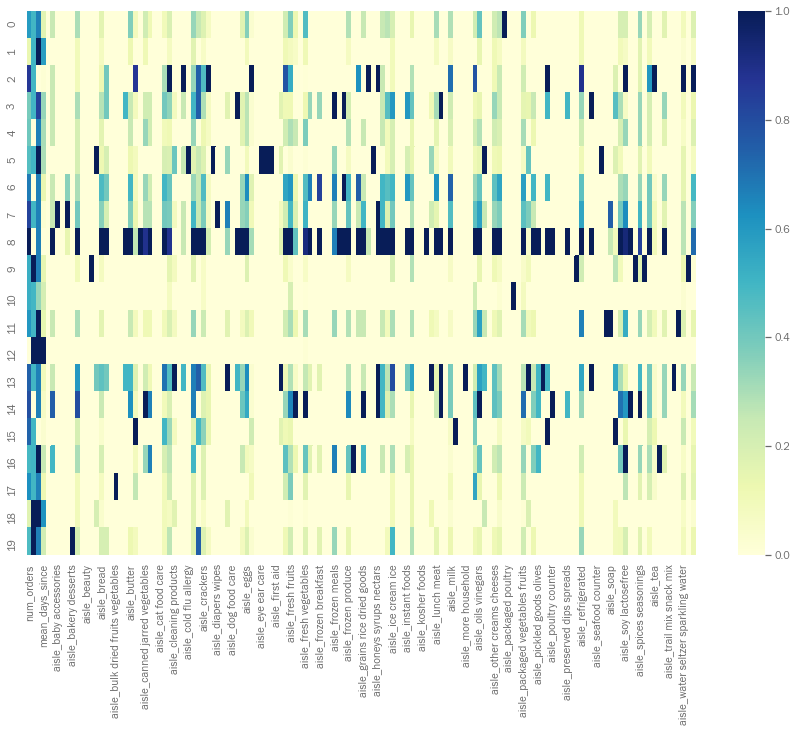

In [155]:
# Make a heatmap of clusters and aisles
# Scale the data first to make it more meaningful
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
graph_data = scaler.fit_transform(cluster_data)
graph_df=pd.DataFrame(graph_data, columns = cluster_data.columns)
fig = plt.figure(figsize=(15,10))
heat_map = sns.heatmap(graph_df, cmap="YlGnBu")
plt.savefig('Images/cluster_heatmap.png')

In [156]:
# Can I write a function to predict what cluster someone will belong in?
# They would have to give me a shopping list... no even then some clusters may be based on order frequency rather than item.
# Or rather, if they give me an item, can I ouput "Others who bought this item also bought..."
# That we will get from the recommendation system below I think

## Surprise recommendation model

The name SurPRISE (roughly :) ) stands for Simple Python RecommendatIon System Engine.

### Prepare data for recommendation system

In [157]:
# Ok so I need user_id, product_id, and 'number of times it was purchased'

merged_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks
2,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,dairy eggs
3,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household
4,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,popcorn jerky,snacks


In [158]:
user_item = merged_orders[['user_id', 'product_id', 'reordered']] # Maybe I can use the reordered flag to increment
user_item

,user_id,product_id,reordered
0,1,196,0
1,1,26088,0
2,1,14084,0
3,1,26405,0
4,1,12427,0
...,...,...,...
33819101,206209,6846,1
33819102,206209,40603,0
33819103,206209,37966,0
33819104,206209,15655,0


In [159]:
# About 20 million duplicates.  That is a person ordering an item more than once.
user_item[user_item.duplicated(subset = ['user_id', 'product_id'], keep = 'first')]

,user_id,product_id,reordered
6,1,196,1
7,1,26088,1
10,1,12427,1
11,1,196,1
13,1,10258,1
...,...,...,...
33819094,206209,16168,1
33819098,206209,24852,1
33819099,206209,39216,1
33819100,206209,9405,1


In [160]:
# Ah this is what I need.  The value counts of each product id for each user.

user_item[user_item['user_id']==1].product_id.value_counts()

196      11
12427    10
10258    10
25133     9
46149     4
13032     4
26088     3
26405     3
49235     3
38928     2
13176     2
39657     2
41787     1
27845     1
10326     1
17122     1
35951     1
30450     1
14084     1
Name: product_id, dtype: int64

In [161]:
# Started at 8:51pm, ended 11:13pm

# Creates list of data tuples of user, product, count

# data=[]
# data_columns=['user_id','product_id','count']
# for user in user_item.user_id.unique():
#     counts = user_item[user_item['user_id']==user].product_id.value_counts()
#     for i in range(len(counts)):
#         data.append([user, counts.index[i], counts.values[i]])

In [162]:
# Began 11:13pm, ended 11:24

# Makes dataframe for recommender

# Now I am consolidated down to 13.8 million rows

# rec_df = pd.DataFrame(data, columns=data_columns)
# rec_df

In [163]:
# pickle.dump(rec_df, open("rec_df.p", "wb"))

In [164]:
rec_df = pickle.load(open("rec_df.p", "rb"))
len(rec_df)

13863746

In [165]:
rec_df[rec_df['user_id']==1]

,user_id,product_id,count
0,1,196,11
1,1,12427,10
2,1,10258,10
3,1,25133,9
4,1,46149,4
5,1,13032,4
6,1,26088,3
7,1,26405,3
8,1,49235,3
9,1,38928,2


In [166]:
#  Hmm. No one bought anything more than 100 times.  Is that coincidental?

rec_df['count'].max()

100

In [167]:
# 8.3 million user/product combinations happened only once

rec_df['count'].value_counts()

1      8299266
2      2296606
3      1074345
4       612369
5       384418
        ...   
94           5
97           4
99           4
100          3
98           2
Name: count, Length: 100, dtype: int64

In [168]:
rec_df['user_id'].nunique()

206209

In [169]:
rec_df['product_id'].nunique()

49685

In [170]:
# In case I want a smaller subset of users I'll build users_150K
# But I wonder if pulling out items only ordered once or users who only ordered once would be better

users_150K = rec_df[rec_df['user_id'] < 150000]

In [193]:
grouped_users[grouped_users['num_orders']<=5] # 49000 users with 5 or fewer orders

,num_orders,mode_order_dow,median_order_hour,mean_days_since,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,...,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
4,5,4,13.0,15.357143,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,12
5,5,0,16.0,12.314286,1.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,12
6,3,4,17.0,7.800000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
8,4,1,0.0,22.173913,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12
9,4,5,12.0,26.117647,0.0,0.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,28.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206184,5,2,11.0,24.705882,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
206186,4,6,15.0,16.200000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,12
206196,5,6,15.0,25.569767,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,7.0,0.0,0.0,12


In [208]:
products_with_count = rec_df.groupby('product_id').sum().drop(columns='user_id').sort_values(by='count')
products_with_count[products_with_count['count']<=5]  # 2741 products ordered 5 times or less

,count
product_id,
36233,1
11254,1
43098,1
14485,1
7626,1
...,...
8009,5
45085,5
6525,5


### Modeling a recommendation system

In [ ]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV
from surprise import accuracy

In [ ]:
# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, 100))

# The columns must correspond to user id, item id and ratings (in that order).
rec_data = Dataset.load_from_df(rec_df, reader)

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(rec_data, test_size=.25, random_state=12)

In [ ]:
# Start with a memory-based model

sim_cos = {'name':'cosine', 'user_based':False}

tic = time.time()

basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(trainset)

fit_time = time.time()-tic
print('fit ', fit_time)

In [ ]:
basic.sim

In [ ]:
predictions = basic.test(testset)
print(accuracy.rmse(predictions))

In [ ]:
sim_pearson = {'name':'pearson', 'user_based':False}
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions = basic_pearson.test(testset)
print(accuracy.rmse(predictions))

In [ ]:
sim_pearson = {'name':'pearson', 'user_based':False}
knn_means = knns.KNNWithMeans(sim_options=sim_pearson)
knn_means.fit(trainset)
predictions = knn_means.test(testset)
print(accuracy.rmse(predictions))

In [ ]:
sim_pearson = {'name':'pearson', 'user_based':False}
knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)
print(accuracy.rmse(predictions))

In [ ]:
# param_grid = {'n_factors':[20, 100],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
#               'reg_all': [0.4, 0.6]}
# gs_model = GridSearchCV(SVD,param_grid=param_grid,n_jobs = -1,joblib_verbose=5)
# gs_model.fit(rec_df)

In [216]:


# Cant believe I got this to work on the whole data set

tic = time.time()


algo = SVD()
# algo = KNNBasic()
# algo = KNNBaseline()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)

fit_time = time.time()-tic
print('fit ', fit_time)
toc = time.time()

predictions = algo.test(testset)

pred_time = time.time()-toc
print('pred ', pred_time)

# Then compute RMSE
accuracy.rmse(predictions)


"algo = SVD()\n# algo = KNNBasic()\n# algo = KNNBaseline()\n\n# Train the algorithm on the trainset, and predict ratings for the testset\nalgo.fit(trainset)\n\nfit_time = time.time()-tic\nprint('fit ', fit_time)\ntoc = time.time()\n\npredictions = algo.test(testset)\n\npred_time = time.time()-toc\nprint('pred ', pred_time)\n\n# Then compute RMSE\naccuracy.rmse(predictions)"

In [210]:
# pickle.dump(algo, open("algo.p", "wb"))

In [211]:
algo = pickle.load(open("algo.p", "rb"))

In [213]:
# Picking a random user to look at oe of their ratings

rec_df[rec_df['user_id'] == 196]

,user_id,product_id,count
12354,196,13176,2
12355,196,1957,1


In [215]:
trainset[196]

NameError: name 'trainset' is not defined

In [214]:
str(196).to_inner_uid()

AttributeError: 'str' object has no attribute 'to_inner_uid'

In [212]:
uid = str(196)  # raw user id (as in the ratings file). They are **strings**!
iid = str(13176)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=2, verbose=True)

user: 196        item: 13176      r_ui = 2.00   est = 2.44   {'was_impossible': False}


In [274]:
testset[0]

(15396, 24010, 1.0)

In [275]:
uid = str(15396)  # raw user id (as in the ratings file). They are **strings**!
iid = str(24010)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=1, verbose=True)

user: 15396      item: 24010      r_ui = 1.00   est = 2.44   {'was_impossible': False}


In [276]:
predictions[0]

Prediction(uid=15396, iid=24010, r_ui=1.0, est=2.086656112459474, details={'was_impossible': False})

In [277]:
predictions[1]

Prediction(uid=171310, iid=893, r_ui=1.0, est=1.007862410058288, details={'was_impossible': False})

In [279]:
pred = algo.predict('171310','893', r_ui=1.0, verbose=True)

user: 171310     item: 893        r_ui = 1.00   est = 2.44   {'was_impossible': False}


In [ ]:
algo.trainset.knows_user(1)
True
algo.trainset.knows_item(0)
True
algo.predict('1','0',4)
Prediction(uid='1', iid='0', r_ui=4, est=3.5444502774861255, details={u'reason': '', u'was_impossible': True})

Actually you can use algo.test(), which works on large number of records. This is what I do:

test.loc[:, 'rating'] = 0 # fill in a dummy rating column since it is required in step 2
test_processed = Dataset.load_from_df(test[['user_id','book_id','rating']], reader) # use load_from_df to convert the test dataframe to the Dataset format required by step 3
NA, test = train_test_split(test_processed, test_size=1.0) # use train_test_split to convert test_processed to list of tuples required in step 4
predictions = algo.test(test)
est = [i.est for i in predictions] # retrieve the est from prediction results.
I used this method to predict on 7M records and it takes about 10 mins on my Macbook Pro.

to_inner_uid(), to_inner_iid(), to_raw_uid(), and to_raw_iid() methods of the trainset

In [ ]:
trainset[0]

In [280]:
from surprise.model_selection import GridSearchCV

# Use movielens-100K
# data = Dataset.load_builtin('ml-100k')

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

# param_grid = {'bsl_options': {'method': ['als', 'sgd'],
#                               'reg': [1, 2]},
#               'k': [2, 3],
#               'sim_options': {'name': ['msd', 'cosine'],
#                               'min_support': [1, 5],
#                               'user_based': [False]}
#               }

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(trainset)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

AttributeError: 'Trainset' object has no attribute 'raw_ratings'

In [ ]:
results_df = pd.DataFrame.from_dict(gs.cv_results)

## Metadata recommender

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
products_desc

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry
...,...,...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5,spirits,alcohol
49684,49685,En Croute Roast Hazelnut Cranberry,42,1,frozen vegan vegetarian,frozen
49685,49686,Artisan Baguette,112,3,bread,bakery
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8,cat food care,pets


In [39]:
products_desc['metadata'] = products_desc.apply(lambda x : x['aisle']+' '+x['department']+' '+x['product_name'], axis = 1)

In [40]:
products_desc

,product_id,product_name,aisle_id,department_id,aisle,department,metadata
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,cookies cakes snacks Chocolate Sandwich Cookies
1,2,All-Seasons Salt,104,13,spices seasonings,pantry,spices seasonings pantry All-Seasons Salt
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages,tea beverages Robust Golden Unsweetened Oolong...
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen,frozen meals frozen Smart Ones Classic Favorit...
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry,marinades meat preparation pantry Green Chile ...
...,...,...,...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5,spirits,alcohol,"spirits alcohol Vodka, Triple Distilled, Twist..."
49684,49685,En Croute Roast Hazelnut Cranberry,42,1,frozen vegan vegetarian,frozen,frozen vegan vegetarian frozen En Croute Roast...
49685,49686,Artisan Baguette,112,3,bread,bakery,bread bakery Artisan Baguette
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8,cat food care,pets,cat food care pets Smartblend Healthy Metaboli...


In [41]:
predicted_products = products_desc[['product_id','product_name']]

count_vec = CountVectorizer(stop_words='english')
count_vec_matrix = count_vec.fit_transform(products_desc['metadata'])
# cosine_sim_matrix = cosine_similarity(count_vec_matrix, count_vec_matrix)
mapping = pd.Series(predicted_products.index, index = predicted_products['product_name'])

In [42]:
# import pickle
# pickle.dump(cosine_sim_matrix, open("cosine_sim_matrix.p", "wb"))

In [ ]:
cosine_sim_matrix = pickle.load(open("cosine_sim_matrix.p", "rb"))

In [43]:
def recommend_products_based_on_metadata(product_input):
    
    product_index = mapping[product_input]
    
    similarity_score = list(enumerate(cosine_sim_matrix[product_index]))
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    
    similarity_score = similarity_score[1:11]
    product_indices = [i[0] for i in similarity_score]
    
    return (products_desc['product_name'].iloc[product_indices])

In [44]:
recommend_products_based_on_metadata('Over Tired and Cranky Bubble Bath')

18225                            Baby Bubble Bath
7544                     Baby Bedtime Bubble Bath
16699                      Baby Bee Bubble Bath -
11065                    Bubble Bath Extra Gentle
42324                 Eucalyptus Mint Bubble Bath
35243                     Bedtime Bath™ Baby Bath
3490           Everyday Shea Lavender Bubble Bath
11443                           Bedtime Baby Bath
18399                           Baby Bedtime Bath
42859    Super Sensitive No Fragrance Bubble Bath
Name: product_name, dtype: object

In [45]:
recommend_products_based_on_metadata('Chocolate Sandwich Cookies')

12480             Oreo Chocolate Sandwich Cookies
23931            Chocolate Creme Sandwich Cookies
1623                            Chocolate Cookies
4641      K-Toos Chocolate Sandwich Cream Cookies
9293       Reduced Fat Chocolate Sandwich Cookies
11638      Chocolate Berry Creme Sandwich Cookies
22413       Chocolate Mint Creme Sandwich Cookies
25636    Birthday Cake Chocolate Sandwich Cookies
4690                       Creme Sandwich Cookies
14715                     Marble Sandwich Cookies
Name: product_name, dtype: object

In [46]:
recommend_products_based_on_metadata('Premium Almonds')

13638                          Sliced Almonds
25425                      Premium Strawberry
16833              Premium Quality Cornstarch
25701               Blanched Slivered Almonds
44890               Unsalted Slivered Almonds
8780      Premium Baking Chips Milk Chocolate
27177      Classic White Premium Baking Chips
8221     Unsalted Slivered California Almonds
33219         Natural Unsalted Sliced Almonds
40928                            Baking Blend
Name: product_name, dtype: object

## Prepare Data for Market Basket Analysis

## Market Basket Analysis

In [ ]:
pip install efficient-apriori

In [ ]:
from efficient_apriori import apriori

In [ ]:
transactions = [('eggs', 'bacon', 'soup'),
                ('eggs', 'bacon', 'apple'),
                ('soup', 'bacon', 'banana')]
itemsets, rules = apriori(transactions, min_support=0.5, min_confidence=1)
print(rules)  # [{eggs} -> {bacon}, {soup} -> {bacon}]

In [ ]:
transactions = [('eggs', 'bacon', 'soup'),
                ('eggs', 'bacon', 'apple'),
                ('soup', 'bacon', 'banana')]
itemsets, rules = apriori(transactions, min_support=0.2, min_confidence=1)

# Print out every rule with 2 items on the left hand side,
# 1 item on the right hand side, sorted by lift
rules_rhs = filter(lambda rule: len(rule.lhs) == 2 and len(rule.rhs) == 1, rules)
for rule in sorted(rules_rhs, key=lambda rule: rule.lift):
  print(rule)  # Prints the rule and its confidence, support, lift, ...

In [ ]:
transactions = [('eggs', 'bacon', 'soup'),
                ('eggs', 'bacon', 'apple'),
                ('soup', 'bacon', 'banana')]
itemsets, rules = apriori(transactions, output_transaction_ids=True)
print(itemsets)
# {1: {('bacon',): ItemsetCount(itemset_count=3, members={0, 1, 2}), ...

## Interpret Results / Conclusions

In [ ]:
pd.DataFrame([Philly_metrics, Indy_metrics, Daytona_metrics, Columbus_metrics, KC_metrics, Chattanooga_metrics])

In [ ]:
def final_ROI(dfs, forecasts):
    comparison = pd.DataFrame(index=['Zip Code','median housing price','actual 2018 ROI', 'forecast 2018 ROI'])
    for i, df in enumerate(dfs):
        metrics = [df['RegionName'][0], df.iloc[0,-1], round(100*df['recent_1_yr_ROI'][0],2), 
                   round(100*calc_forecast_ROI(forecasts[i]),2)]
        comparison[df['City'][0]] = metrics        
    return comparison

ROI_comparison = final_ROI(original_dfs, forecast_dfs)
ROI_comparison

Results: 

* Cluster data is fabulous for market segmentation and targeted marketing
* 
* All training data outperformed the test data.
* The models are all very skewed because of the market crash in 2009.
* Columbus and Daytona had very large confidence intervals and overly high forecasts.
* Chattanooga has outperformed even the confidence intervals of the model.
* Philadelphia is potentially a good 50K investment , Indianapolis at 75K and Chattanooga at 100K investment

Caveats: 
* Logged and differenced the data but some still did not test as stationary according to the Dickey Fuller test.
* Real estate predictions can vary due to unseen fluctuations in the market

Next Steps/Future Work: 

* Go back and cluster again allowing more than 20 clusters to make some of the big clusters smaller?  
* Cluster by what portion of each order was from each aisle rather than number of items?  
* Analyze which clusters buy the most products **per person**  


## Move data in SQL tables (on AWS?)

In [69]:
# from sqlalchemy import create_engine

# engine = create_engine('sqlite:///grocery.db', echo=True)

In [70]:
# user_data.to_sql('users', con=engine, if_exists='replace')

2021-02-09 17:58:13,407 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2021-02-09 17:58:13,410 INFO sqlalchemy.engine.base.Engine ()
2021-02-09 17:58:13,411 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2021-02-09 17:58:13,412 INFO sqlalchemy.engine.base.Engine ()
2021-02-09 17:58:13,415 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("users")
2021-02-09 17:58:13,416 INFO sqlalchemy.engine.base.Engine ()
2021-02-09 17:58:13,422 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("users")
2021-02-09 17:58:13,423 INFO sqlalchemy.engine.base.Engine ()
2021-02-09 17:58:13,425 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2021-02-09 17:58:13,426 INFO sqlalchemy.engine.base.Engine ()
2021-02-09 17:58:13,428 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_xinfo("users")
2021-02-09 17:58:13,428 INFO sqlalchemy.engine.base.Eng

MemoryError: Unable to allocate 258. MiB for an array with shape (33819106,) and data type object

In [ ]:
# result = engine.execute('SELECT * from users;')
# pd.DataFrame(result.fetchall(), columns = result.keys())